# Machine Learning I - Practical I

Name: Dennis Perrett

Course: Machine Learning 1

This notebook provides you with the assignments and the overall code structure you need to complete the assignment. Each exercise indicates the total number of points allocated. There are also questions that you need to answer in text form. Please use full sentences and reasonably correct spelling/grammar.

Regarding submission & grading:

- Solutions can be uploaded to ILIAS until the indicated deadline. Please upload a copy of this notebook and a PDF version of it after you ran it.

- Please hand in your own solution. You are encouraged to discuss your code with classmates and help each other, but after that, please sit down for yourself and write your own code. 

- We will grade not only based on the outputs, but also look at the code. So please use comments make us understand what you intended to do :)

- For plots you create yourself, all axes must be labeled. 

- DO NOT IN ANY CASE change the function interfaces.

- If you are not familiar with python, then this may be of help. This is a colab notebook which is part of the Convolutional Neural Networks for Visual Recognition course (CS231n) in Stanford. It goes through some of the basic elements of Python and Numpy. You can run it directly in the browser without having Python installed:
    
    https://colab.research.google.com/github/cs231n/cs231n.github.io/blob/master/python-colab.ipynb#scrollTo=U1PvreR9L9eW  
    

- If you are not familiar with python, but used MATLAB before, check out this reference pages listing what you want to use as python equivalent of a certain MATLAB command:

    https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html
    
    http://www.eas.uccs.edu/~mwickert/ece5650/notes/NumPy2MATLAB.pdf
    
    http://mathesaurus.sourceforge.net/matlab-python-xref.pdf
    
    or, if you prefer to read a longer article, try: 
    
    https://realpython.com/matlab-vs-python/#learning-about-pythons-mathematical-libraries
    
    

In [121]:
%matplotlib inline


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy import stats
import copy
import pylab
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

## The  dataset

The dataset consists of over 20.000 materials and lists their physical features. From these features, we want to learn how to predict the critical temperature, i.e. the temperature we need to cool the material to so it becomes superconductive. First load and familiarize yourself with the data set a bit.

In [122]:
data=pd.read_csv('superconduct_train.csv')
print(data.shape)

(21263, 82)


In [123]:
data.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


Because the dataset is rather large, we prepare a small subset of the data as training set, and another subset as test set. To make the computations reproducible, we set the random seed.

In [124]:
target_clm = 'critical_temp' # the critical temperature is our target variable
n_trainset = 200 # size of the training set
n_testset = 500 #size of the test set

In [125]:
# set random seed to make sure every test set is the same
np.random.seed(seed=1)

idx = np.arange(data.shape[0])
idx_shuffled = np.random.permutation(idx) # shuffle indices to split into training and test set

test_idx = idx_shuffled[:n_testset]
train_idx = idx_shuffled[n_testset:n_testset+n_trainset]
train_full_idx = idx_shuffled[n_testset:]

X_test = data.loc[test_idx, data.columns != target_clm].values
y_test = data.loc[test_idx, data.columns == target_clm].values
print('Test set shapes (X and y)', X_test.shape, y_test.shape)

X_train = data.loc[train_idx, data.columns != target_clm].values
y_train = data.loc[train_idx, data.columns == target_clm].values
print('Small training set shapes (X and y):',X_train.shape, y_train.shape)

X_train_full = data.loc[train_full_idx, data.columns != target_clm].values
y_train_full = data.loc[train_full_idx, data.columns == target_clm].values
print('Full training set shapes (X and y):',X_train_full.shape, y_train_full.shape)

Test set shapes (X and y) (500, 81) (500, 1)
Small training set shapes (X and y): (200, 81) (200, 1)
Full training set shapes (X and y): (20763, 81) (20763, 1)


## Task 1: Plot the dataset [5 pts]

To explore the dataset, use `X_train_full` and `y_train_full` for two descriptive plots:

* **Histogram** of the target variable. Use `plt.hist`.

* **Scatterplots** relating the target variable to one of the feature values. For this you will need 81 scatterplots. Arrange them in one big figure with 9x9 subplots. Use `plt.scatter`. You may need to adjust the marker size and the alpha blending value. 

/var/folders/7q/rpkqc9bn44zcj9yyxf_qhb3c0000gn/T/ipykernel_37921/2835899094.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


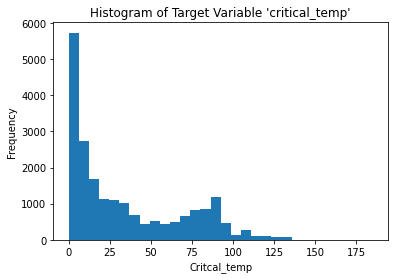

In [126]:
# Histogram of the target variable
fig = plt.figure()
plt.title(f"Histogram of Target Variable '{target_clm}'")
plt.ylabel("Frequency")
plt.xlabel("Critcal_temp")
plt.hist(y_train_full,bins=30);
fig.show()

/var/folders/7q/rpkqc9bn44zcj9yyxf_qhb3c0000gn/T/ipykernel_37921/703371747.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


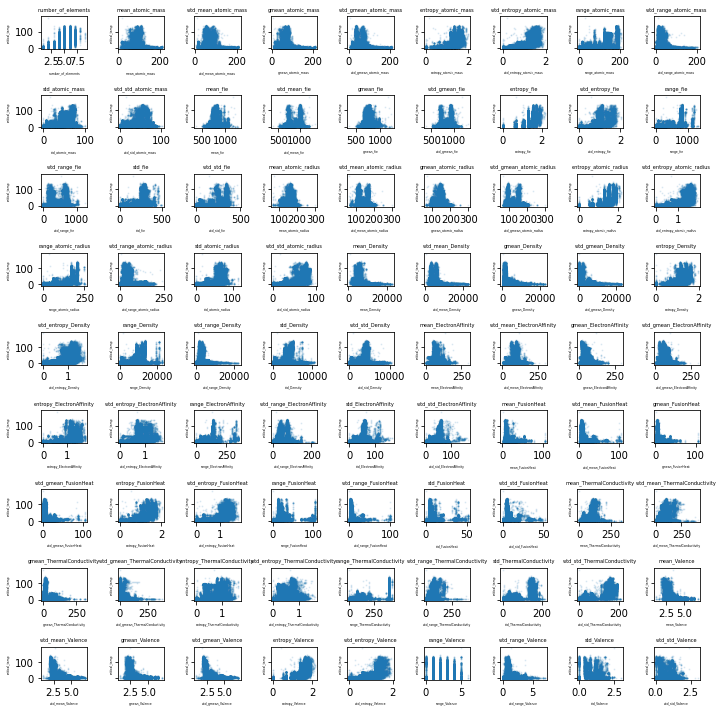

In [127]:
# Scatter plots of the target variable vs. features

fig, axs = plt.subplots(9,9,figsize=(10,10),sharey=True)


# marker symbol

for i, ax in enumerate(axs.flat): 
    ax.scatter(X_train_full[:,i],y_train_full,alpha=.1,s=1)
    ax.set_title(data.columns[i],fontsize=5)
    ax.set_ylabel(target_clm,fontsize=3)
    ax.set_xlabel(data.columns[i],fontsize=3)
    
fig.tight_layout()
fig.show()

Which material properties may be useful for predicting superconductivity? What other observations can you make?

***
### Answer:

When looking for features that may be useful for predicting the target variable, we look for any form of pattern between the target and predictor feature.

Among others, a feature like wtd_mean_ThermalConductivity (above: 3nd to last row, last column) shows what could potentially result in a linear relationship.

There do appear to be many "L" shaped relationships, which are likely to be helpful for predicting. One would likely have to transform this variable to make the relationship a bit more linear.

Additionally, from the histogram above, we see that the y data are very much non-normal, and quick analysis (not shown) suggests taking the square root of y. Besides being better for the underlying assumptions of the model, this may also highlight correlations between the data not visible in the plots above (eg: wtd_entropy_atomic_mass).
***

## Task 2:  Implement your own OLS estimator [10 pts]

We want to use linear regression to predict the critical temperature. Implement the ordinary least squares estimator without regularization 'by hand':

$w = (X^TX)^{-1}X^Ty$

To make life a bit easier, we provide a function that can be used to plot regression results. In addition it computes the mean squared error and the squared correlation between the true and predicted values. 

In [128]:
def plot_regression_results(y_test,y_pred,weights):
    '''Produces three plots to analyze the results of linear regression:
        -True vs predicted
        -Raw residual histogram
        -Weight histogram
        
    Inputs:
        y_test: (n_observations,) numpy array with true values
        y_pred: (n_observations,) numpy array with predicted values
        weights: (n_weights) numpy array with regression weights'''
    
    print('MSE: ', mean_squared_error(y_test,y_pred))
    print('r^2: ', r2_score(y_test,y_pred))
    
    fig,ax = plt.subplots(1,3,figsize=(9,3))
    #predicted vs true
    ax[0].scatter(y_test,y_pred)
    ax[0].set_title('True vs. Predicted')
    ax[0].set_xlabel('True %s' % (target_clm))
    ax[0].set_ylabel('Predicted %s' % (target_clm))

    #residuals
    error = np.squeeze(np.array(y_test)) - np.squeeze(np.array(y_pred))
    ax[1].hist(np.array(error),bins=30)
    ax[1].set_title('Raw residuals')
    ax[1].set_xlabel('(true-predicted)')

    #weight histogram
    ax[2].hist(weights,bins=30)
    ax[2].set_title('weight histogram')

    plt.tight_layout()

As an example, we here show you how to use this function with random data. 

MSE:  2640.432578444892
r^2:  -1.108062856115481


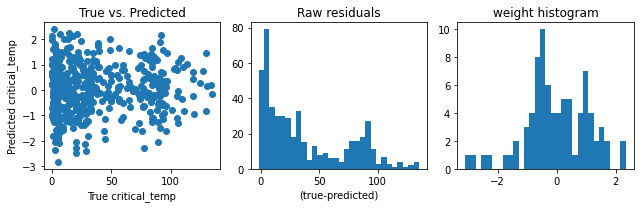

In [129]:
# weights is a vector of length 82: the first value is the intercept (beta0), then 81 coefficients
weights = np.random.randn(82)

# Model predictions on the test set
y_pred_test = np.random.randn(y_test.size)

plot_regression_results(y_test, y_pred_test, weights)

Implement OLS linear regression yourself. Use `X_train` and `y_train` for estimating the weights, and use `X_test` to compute test set predictions. `OLS_regression` is supposed to return those. Call our plotting function with the regession result to compute the MSE and $r^2$. You should get mean squared error of 599.7.

In [130]:
def OLS_regression(X_test, X_train, y_train):
    '''Computes OLS weights for linear regression without regularization on the training set and 
       returns weights and testset predictions.
    
       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set 
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         
       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set
         
       Note:
         Both the training and the test set need to be appended manually by a columns of 1s to add
         an offset term to the linear regression model.        
    
    '''
    
    # ADD YOUR CODE HERE
    
    

    # Add intercept to X
    int_vec = np.ones((len(X_train),1))
    X_train = np.hstack((int_vec,X_train))
    int_vec = np.ones((len(X_test),1))
    X_test = np.hstack((int_vec,X_test))
    
    # SVD Decomposition for efficiency. 
    #Normal formula would obviously be:
    # np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
    u, s, vh = np.linalg.svd(X_train, full_matrices=False)
    s = np.diag(s)
    v = vh.T
    
    weights = v @ np.linalg.inv(s) @ u.T @ y_train
    y_pred = X_test @ weights
    
    
    
    return weights, y_pred




MSE:  599.7397626158044
r^2:  0.5211810643351067


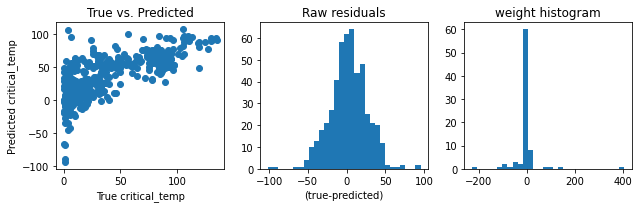

In [131]:
weights, y_pred = OLS_regression(X_test, X_train, y_train)
plot_regression_results(y_test, y_pred, weights)

What do you observe? Is the linear regression model good?

### ANSWER

Examining the R^2, the model is very much "ok" at best. With roughly 52% of the variance in Y is explained by the linear combination of X variables and weights. One would hope for at least above .7 before being happy with the model.

Residuals look good for a start. Residuals should be normally distributed, which they appear to be.

The ideal True vs Predicted plot would depict a straight line from bottom left to top right. I have seen worse plots before, but there does seem to be a decent amount mis-specification/estimation with lower true values being predicted as much higher/lower than they should be. Likely because the Y data are not yet transformed for normality. 

There do appear to be some heavily weighted variables, while this is not strictly an issue (as the weight depends on the scale of the data), this is characteristic of overfitting.

A quick note on MSE: This is an absolute term, and is only useful for comparing performance between models. 

## Task 3: Compare your implementation to sklearn [5 pts]

Now, familarize yourself with the sklearn library. In the section on linear models:

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

you will find `sklearn.linear_model.LinearRegression`, the `sklearn` implementation of the OLS estimator. Use this sklearn class to implement OLS linear regression. Again obtain estimates of the weights on `X_train` and `y_train` and compute the MSE and $r^2$ on `X_test`.


In [132]:
def sklearn_regression(X_test, X_train, y_train):
    '''Computes OLS weights for linear regression without regularization using the sklearn library on the training set and 
       returns weights and testset predictions.
    
       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set 
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         
       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set
          
         
       Note:
         The sklearn library automatically takes care of adding a column for the offset.     
    
    '''
    
    
    # ADD YOUR CODE HERE
    
    model = linear_model.LinearRegression()
    reg = model.fit(y=y_train,X=X_train)
    
    weights = reg.coef_[0]
    y_pred = reg.predict(X_test)
    
    return weights, y_pred

MSE:  599.7397626159245
r^2:  0.5211810643350108


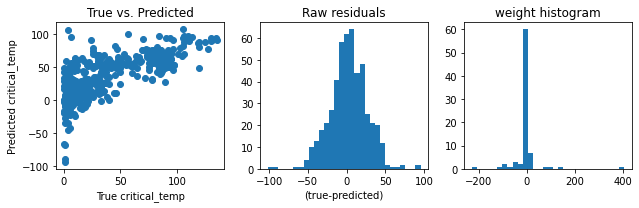

In [133]:
weights, y_pred = sklearn_regression(X_test, X_train, y_train)

plot_regression_results(y_test, y_pred, weights)

If you implemented everything correctly, the MSE is again 599.74.

Fit the model using the larger training set, `X_train_full` and `y_train_full`, and again evaluate on `X_test`.

MSE:  329.86070104111064
r^2:  0.7366465263178499


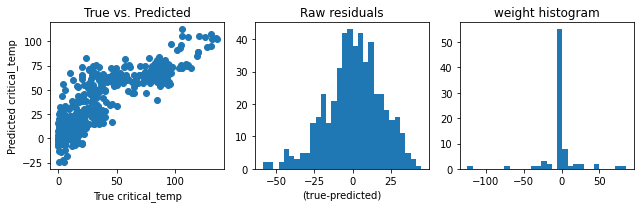

In [134]:
weights, y_pred = sklearn_regression(X_test, X_train_full, y_train_full)
plot_regression_results(y_test, y_pred, weights)

How does test set performance change? What else changes?

***
### ANSWER
The R^2 increases dramatically from roughly .5 to .7. This is a "big increase in performance". It is however important to note, that using the full dataset to train and test the model, it is very likely that this model has been overfit with regard to the training set.

This "better performance" is also evidenced by the much more linear True vs Predicted plot. The distribution of the weights has also changed, with the variance decreasing. There are still some larrger weights, which as mentioned above, may indicate overfitting.

Again, very important to note, that while the metrics suggest a better model, the model may not generalise well at all when given more data, i.e. Model has overfit the data.
***

## Task 4: Regularization with ridge regression [15 pts]

We will now explore how a penalty term on the weights can improve the prediction quality for finite data sets. Implement the analytical solution of ridge regression 

$w = (X^TX + \alpha I_D)^{-1}X^Ty$


as a function that can take different values of $\alpha$, the regularization strength, as an input. In the lecture, this parameter was called $\lambda$, but this is a reserved keyword in Python.

In [135]:
def ridge_regression(X_test, X_train, y_train, alpha):
    '''Computes OLS weights for regularized linear regression with regularization strength alpha 
       on the training set and returns weights and testset predictions.
    
       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set 
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         alpha: scalar, regularization strength
         
       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set
          
       Note:
         Both the training and the test set need to be appended manually by a columns of 1s to add
         an offset term to the linear regression model.       
    
    '''
    
    
    """"""

    # ADD YOUR CODE HERE

    
    
    # Currently penalising the intercept.
    # Ideally we would want to center the data as to not penalise the intercept, but this results in a MSE
    # that is not in line with the MSE suggested (~600) in the exercises. As a result, this is the equation
    # for Ridge regression without centering the data, and as such, penalising the intercept.
    
    # Add the intercept
    def add_intercept(X):
        X1 = np.ones((X.shape[0],X.shape[1]+1))
        X1[:,1:] = X
        return X1
    
    # add intercept to data
    X_train = add_intercept(X_train)
    X_test = add_intercept(X_test)

    
    # calculate weights
    weights = np.linalg.inv(X_train.T@X_train + alpha*np.identity(X_train.shape[1]))@X_train.T @ y_train
    y_pred = X_test @ weights
    
    # Return weights.T[0] due to formatting for later
    return weights.T[0], y_pred

Now test a range of log-spaced $\alpha$s (~10-20), which cover several orders of magnitude, e.g. from 10^-7 to 10^7. 

* For each $\alpha$, you will get one model with one set of weights. 
* For each model, compute the error on the test set. 

Store both the errors and weights of all models for later use. You can use the function `mean_squared_error` from sklearn (imported above) to compute the MSE.


In [136]:
alphas = np.logspace(-7,7,100)
    
# ADD YOUR CODE HERE
weightings = []
MSEs = []

# Testing against all alphas (unsure if we are to test only against a subset of the given alphas). 
for alpha in alphas:
    weights, y_pred = ridge_regression(X_test, X_train, y_train, alpha)
    
    weightings.append(weights)
    MSEs.append(mean_squared_error(y_pred,y_test))
    
weightings = np.array(weightings)

Make a single plot that shows for each coefficient how it changes with $\alpha$, i.e. one line per coefficient. Also think about which scale (linear or log) is appropriate for your $\alpha$-axis. You can set this using `plt.xscale(...)`.

/var/folders/7q/rpkqc9bn44zcj9yyxf_qhb3c0000gn/T/ipykernel_37921/3473882158.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


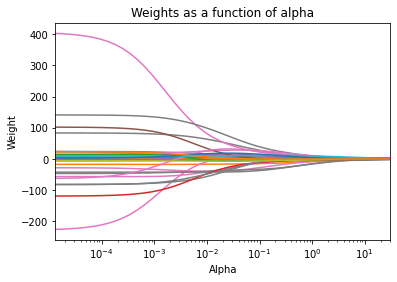

In [137]:
fig = plt.figure()

for w in weightings.T:
    plt.plot(alphas,w)
plt.title("Weights as a function of alpha")
plt.ylabel("Weight")
plt.xlabel("Alpha")
plt.xscale("log")
plt.xlim([alphas[15], alphas[60]])

fig.show()

Why are the values of the weights largest on the left? Do they all change monotonically? 

***
### ANSWER

As ridge regression constrains the overall size of the the squared beta vector (i.e. the sum of all squared betas) as opposed to restricting the absolute size of each beta, the value of smaller betas can theoretically increase while large betas decrease, all while reducing the overall sum, i.e. they do not all change monotonically. 

That being said, as alpha approaches infinity, the betas approach 0. We see this in the above figure.

Additionally, an alpha of 0 is equivalent to OLS (i.e. un-regularised). This is why the weights are typically largest on the left, as there they are not penalised whatsoever.


***

Plot how the performance (i.e. the error) changes as a function of $\alpha$. Again, use appropriate scaling of the x-axis. As a sanity check, the MSE value for very small $\alpha$s should be close to the test-set MSE of the unregularized solution, i.e. 599.

/var/folders/7q/rpkqc9bn44zcj9yyxf_qhb3c0000gn/T/ipykernel_37921/249154048.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


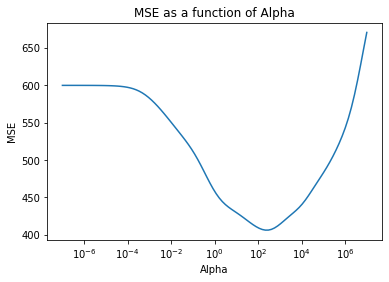

In [138]:
fig = plt.figure()
plt.plot(alphas,MSEs)
plt.title("MSE as a function of Alpha")
plt.ylabel("MSE")
plt.xlabel("Alpha")
plt.xscale("log")
fig.show()

Which value of $\alpha$ gives the minimum MSE? Is it better than the unregularized model? Why should the curve reach ~600 on the left?

***

### Answer:
The value of $\alpha$ that gives the minimum MSE is roughly $10^{2.5}$. This is, at least with regard to MSE, better than the unregularised model. The MSE for the unregularised model was ~600, versus roughly ~400 when regularised with an $\alpha$ of roughly $10^{2.5}$, i.e. ~200 points greater when unregularised. The goal is naturally, to have a small MSE.

The curve should reach ~600, or the un-regularised, MSE on the left (ie where alpha = 0) because a ridge regression with an alpha of 0, is equivalent to OLS, i.e. unregularised.



***

Now implement the same model using sklearn. Use the `linear_model.Ridge` object to do so.


In [139]:
def ridge_regression_sklearn(X_test, X_train, y_train,alpha):
    '''Computes OLS weights for regularized linear regression with regularization strength alpha using the sklearn
       library on the training set and returns weights and testset predictions.
    
       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set 
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         alpha: scalar, regularization strength
         
       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set
          
       Note:
         The sklearn library automatically takes care of adding a column for the offset.     
   
    
    '''
    
    # ADD YOUR CODE HERE
    
    
    # Currently penalising the intercept. Although mentioned in lecture, we determined in the QA session that 
    # it is not necessary to scale the data etc for the intercept to not be penalised.

    # Call model
    model = linear_model.Ridge(alpha=alpha)
    # Fit model
    reg = model.fit(y=y_train,X=X_train)
    
    weights = reg.coef_[0]
    y_pred = reg.predict(X_test)
            
    return weights, y_pred

This time, only plot how the performance changes as a function of $\alpha$. 

/var/folders/7q/rpkqc9bn44zcj9yyxf_qhb3c0000gn/T/ipykernel_37921/357900428.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


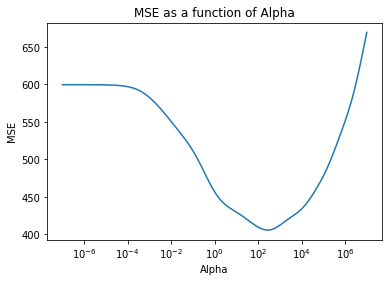

In [140]:
# ADD YOUR CODE HERE
weightings_r = [] # List for weights
MSEs_r = [] # List for MSE

# For each alpha
for alpha in alphas:
    # Fit model/get results
    weights, y_pred = ridge_regression_sklearn(X_test, X_train, y_train, alpha)
    
    # add weights to the the list
    weightings_r.append(weights)
    
    # add MSE to the list
    MSEs_r.append(mean_squared_error(y_test,y_pred))
    
# plot
fig = plt.figure()
plt.title("MSE as a function of Alpha")
plt.ylabel("MSE")
plt.xlabel("Alpha")
plt.plot(alphas,MSEs_r)
plt.xscale("log")
fig.show()



Note: Don't worry if the curve is not exactly identical to the one you got above. The loss function we wrote down in the lecture  has $\alpha$ defined a bit differently compared to sklearn. However, qualitatively it should look the same.

## Task 5: Cross-validation [15 pts]

Until now, we always estimated the error on the test set directly. However, we typically do not want to tune hyperparameters of our inference algorithms like $\alpha$ on the test set, as this may lead to overfitting. Therefore, we tune them on the training set using cross-validation. As discussed in the lecture, the training data is here split in `n_folds`-ways, where each of the folds serves as a held-out dataset in turn and the model is always trained on the remaining data. Implement a function that performs cross-validation for the ridge regression parameter $\alpha$. You can reuse functions written above.

In [141]:
def ridgeCV(X, y, n_folds, alphas):
    '''Runs a n_fold-crossvalidation over the ridge regression parameter alpha. 
       The function should train the linear regression model for each fold on all values of alpha.
    
      Inputs: 
        X: (n_obs, n_features) numpy array - predictor
        y: (n_obs,) numpy array - target
        n_folds: integer - number of CV folds
        alphas: (n_parameters,) - regularization strength parameters to CV over
        
      Outputs:
        cv_results_mse: (n_folds, len(alphas)) numpy array, MSE for each cross-validation fold 
        
      Note: 
        Fix the seed for reproducibility.
        
        '''    
    
    cv_results_mse = np.zeros((n_folds, len(alphas)))
    np.random.seed(seed=2)

    
    # ADD YOUR CODE HERE
    

    n = X.shape[0] # Length of dataset    
    train_size = n//n_folds # Size of data set for each fold
    
    # Shuffle data, split into folds
    idx_p = np.random.permutation(range(n))
    folds = np.array_split(idx_p,n_folds)
    
    # For each fold
    for f, fold in enumerate(folds):

        # Set index selection as index
        idx_test = np.in1d(range(n), fold) # Turn selection into usable index.

        # Select train and test sets
        X_train = X[~idx_test]
        y_train = y[~idx_test]

        X_test = X[idx_test]
        y_test = y[idx_test]
        
        # For each alpha
        for a, alpha in enumerate(alphas):

            # Calculate model
            weights, y_pred = ridge_regression_sklearn(X_test, X_train, y_train, alpha)

            # Calculate MSE
            cv_results_mse[f][a]=mean_squared_error(y_test,y_pred)

            
    return cv_results_mse    

Now we run 10-fold cross-validation using the training data of a range of $\alpha$s.

In [142]:
alphas = np.logspace(-7,7,100)
mse_cv = ridgeCV(X_train, y_train, n_folds=10, alphas=alphas)

We plot the MSE trace for each fold separately:

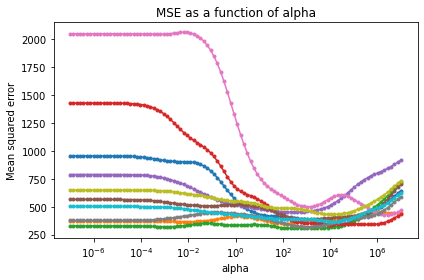

In [143]:
plt.figure(figsize=(6,4))
plt.plot(alphas, mse_cv.T, '.-')
plt.xscale('log')
plt.title('MSE as a function of alpha')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

We also plot the average across folds:

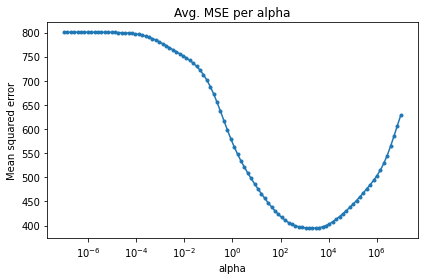

In [144]:
plt.figure(figsize=(6,4))
plt.plot(alphas, np.mean(mse_cv,axis=0), '.-')
plt.xscale('log')
plt.title("Avg. MSE per alpha")
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

What is the optimal $\alpha$? Is it similar to the one found on the test set? Do the cross-validation MSE and the test-set MSE match well or differ strongly?

***
### Answer:
Here the optimal $\alpha$ is slightly larger than $10^{3}$. This is not totally dissimilar to the one found on the test set Ridge Regression (10^2.5 vs 10^3). The shape of the curve, while not identical, follows the same patter/shape as for the test-set MSE. Here however, the MSE is better than for the non-CV model. This is because the cross validation further limits overfitting, and as such, the model generalises better when using test data.

Interestingly, the MSE starts a lot higher on the left (~800 vs 599) than non-CV ridge regression. This difference is simply down to the sampling methods used.

***

We will now run cross-validation on the full training data. This will take a moment, depending on the speed of your computer. Afterwards, we will again plot the mean CV curves for the full data set (blue) and the small data set (orange).

In [145]:
alphas = np.logspace(-7,7,100)
mse_cv_full = ridgeCV(X_train_full, y_train_full, n_folds=10, alphas=alphas)

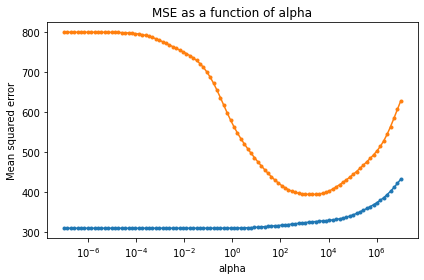

In [146]:
plt.figure(figsize=(6,4))
plt.plot(alphas, np.mean(mse_cv_full,axis=0), '.-')
plt.plot(alphas, np.mean(mse_cv,axis=0), '.-')
plt.xscale('log')
plt.title("MSE as a function of alpha")
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

We determine the (very subtle) minimum of the blue curve and zoom in around it to be able to see it:

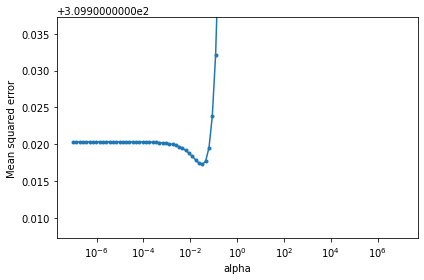

In [147]:
plt.figure(figsize=(6,4))
plt.plot(alphas, np.mean(mse_cv_full,axis=0), '.-')
plt.xscale('log')
minValue = np.min(np.mean(mse_cv_full,axis=0))
plt.ylim([minValue-.01, minValue+.02])
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

Why does the CV curve on the full data set look so different? What is the optimal value of $\alpha$ and why is it so much smaller than on the small training set?

***

### ANSWER

As sample size increases, p/n (parameters/samples) decreases, and in turn, the likelihood to overfit decreases. With the test data, we had 82 parameters, for 200 samples. Using the full dataset, we have 82 parameters for ~21000 samples. The closer one gets to a saturated model (p=n), the more likely it is for the model to overfit the data. By adding samples, we have moved away from a saturated model, and as such, reduced the opportunity for the model to overfit. 

By definition, a non-overfit model generalises better, i.e. performs better on the test/real data. As a result, the MSE will be much smaller using test data.

In this case, because we have used cross validation, there is still room for non-optimal weights, which is why the very small optimal value of alpha (slightly larger than $10^{-2}$) has in fact decreased the MSE by a very small amount. 

If we assume that the due to the large sample size, the weights are in-fact optimal when calculated on the full dataset, increasing alpha will only result in non-optimal weights, which is why we see the blue line above, increase as alpha increases. 